In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
taxons = pd.read_csv('../../data/clean_taxons.csv')

In [ ]:
taxons.columns

NOTE: Consider way to move the top level taxon taxon_name to level1taxon if level1taxon is Nan. At the moment can't do this as would like becuase pensions is toplevel, yet also has parent = work. Think this might change in taxons data update so not going to spend time on it now.

In [26]:
content = pd.read_csv('../../data/clean_content.csv.gz', compression='gzip')

In [30]:
content.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id'],
      dtype='object')

In [11]:
taxons = taxons[['base_path','content_id','taxon_name','level1taxon','level2taxon','level3taxon','level4taxon']]

In [13]:
#For top taxons (level1) ensure that taxon)name is in level1taxon column instead of Nan
taxons['level1taxon'] = taxons['level1taxon'].fillna(taxons['taxon_name'])

### Remove the taxons that we don't want represented in training/test data

Current approach: Take out World and Corporate top taxons   
Must consider that the data which we will predict on needs to come from the same population as training data and it is hard to filter the unlabelled data to remove World & Corporate (unless they are perfectly predicted by a meta var such as documnet type). It may be safer to keep them in the training data, predict on all data and act differently if World/Corporate is predicted?

In [20]:
taxons.shape

(2028, 7)

In [21]:
taxons = taxons[taxons.level1taxon != 'World']
taxons = taxons[taxons.taxon_name != 'World']

print("Taxons shape after deleting 'World' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'World' top taxons: (2028, 7)


In [22]:
taxons = taxons[taxons.level1taxon != 'Corporate information']
taxons = taxons[taxons.taxon_name != 'Corporate information']
print("Taxons shape after deleting 'corporate information' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'corporate information' top taxons: (2027, 7)


In [23]:
# Convert nans to taxon_name

taxons['level1taxon'] = taxons['level1taxon'].where(taxons['level1taxon'] != 'nan', None)
taxons['level2taxon'] = taxons['level2taxon'].where(~taxons['level2taxon'].isnull(), None)

print("Taxons shape after converting nans to Nones: {}".format(taxons.shape))

Taxons shape after converting nans to Nones: (2027, 7)


<p style="border-radius: 25px;background: #73AD21;padding: 20px;width: 400px;height: 50px;color: #FFFFFF;">Not sure if still need this as nones??? ☝️☝️☝️☝️☝️</p>

In [24]:
#This could move down into the description of taxons later
mask = ~taxons['level1taxon'].isnull() & taxons['level2taxon'].isnull()

print("There are {} out of {} taxons with a level2"
      .format(sum(~taxons['level2taxon'].isnull()), taxons.shape[0]))
print("There are {} out of {} taxons with a level1 tag, but no level2 tag"
      .format(sum(mask), taxons.shape[0]))

There are 1791 out of 2027 taxons with a level2
There are 236 out of 2027 taxons with a level1 tag, but no level2 tag


## Join the content items with the taxon information

In [27]:
content_taxons = pd.merge(
    left=content, 
    right=taxons, 
    left_on='taxon_id', 
    right_on='content_id', 
    how='outer', 
    indicator=True
)

In [28]:
assert content_taxons.shape == (335720, 23)
content_taxons.shape

(335720, 23)

In [32]:
content_taxons.head()

,Unnamed: 0,base_path_x,content_id_x,description,details,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,...,variable,taxon_id,base_path_y,content_id_y,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,_merge
0,0.0,/vehicle-tax,fa748fae-3de4-4266-ae85-0797ada3f40c,renew or tax your vehicle for the first time u...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,4.0,/check-vehicle-tax,0889f128-e479-465f-b3e1-a3db6a3879cf,check and report if a vehicle has up-to-date v...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,7.0,/check-mot-history,ad5110e0-fa62-49d3-923f-d50101f12014,check the mot history of a vehicle from 2005 o...,"{'will_continue_on': '', 'department_analytics...",transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,9.0,/check-mot-status,dc57162b-59f4-4d0f-9b83-a67f74ffccf5,find out the mot test status of a vehicle - ch...,{'will_continue_on': 'the vehicle enquiry serv...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,63.0,/vehicle-tax-refund,fff88e3b-ae66-43e4-afd0-6fc1f227b452,your vehicle tax is cancelled and you get a re...,"{'body': '\n<div class=""summary"">\n<p>Cancel y...",answer,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,...,0.0,948b6dd4-45b3-45ab-a5c6-5dbce75542a6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


## Tidy up columns

In [33]:
content_taxons.columns

Index(['Unnamed: 0', 'base_path_x', 'content_id_x', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id', 'base_path_y', 'content_id_y',
       'taxon_name', 'level1taxon', 'level2taxon', 'level3taxon',
       'level4taxon', '_merge'],
      dtype='object')

In [34]:
content_taxons = content_taxons.drop(['Unnamed: 0', 'variable', 'base_path_y', 
                                      'content_id_y', 'details' ], axis=1)

In [35]:
content_taxons.rename(columns={'base_path_x': 'base_path', 
                               'content_id_x': 'content_id'}, inplace=True)

## Training data: filter out rows which are duplicates, or mismatches from merge

In [36]:
print("There are {} rows in the data before filtering".
      format(content_taxons.shape[0]))
print("There are {} unique content items in the data before filtering".
      format(content_taxons.content_id.nunique()))
print("There are {} duplicates content items, both with matching content_id "
      "and taxon_id in the data before filtering"
      .format(content_taxons[content_taxons.duplicated(['content_id', 'taxon_id'])].shape[0]))

There are 335720 rows in the data before filtering
There are 140103 unique content items in the data before filtering
There are 956 duplicates content items, both with matching content_id and taxon_id in the data before filtering


In [37]:
# Drop any rows which were not perfectly matched in taxons and content

content_taxons_filtered = content_taxons[content_taxons._merge == 'both']

print("There are {} rows in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.shape[0]))
print("There are {} unique content items in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.content_id.nunique()))

There are 229461 rows in the taxon-level data after filtering out mismatches
There are 127320 unique content items in the taxon-level data after filtering out mismatches


In [38]:
print("There were {} rows dropped because of mismatching"
      .format(content_taxons.shape[0] - content_taxons_filtered.shape[0]))
print("There were {} unique content items dropped because of mismatching"
      .format(content_taxons.content_id.nunique() - content_taxons_filtered.content_id.nunique()))

There were 106259 rows dropped because of mismatching
There were 12783 unique content items dropped because of mismatching


In [39]:
print("There are {} duplicates content items, both with matching"
      "content_id and taxon_id in after removing mismatches"
      .format(content_taxons_filtered[content_taxons_filtered.
                                      duplicated(['content_id', 'taxon_id'])].shape[0]))

There are 377 duplicates content items, both with matchingcontent_id and taxon_id in after removing mismatches


In [40]:
content_taxons_dedup = content_taxons_filtered.drop_duplicates(subset = ['content_id', 'taxon_id'])

In [43]:
#assert content_taxons_dedup.shape == (2029084, 18)
content_taxons_dedup.shape

(229084, 18)

In [44]:
content_taxons_dedup.head()

,base_path,content_id,description,document_type,first_published_at,locale,primary_publishing_organisation,publishing_app,title,body,combined_text,taxon_id,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,_merge
5,/student-finance-register-login,e57daef4-5eb5-431c-b0ad-14119ab0355f,your student finance online account - check pa...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,student finance login,,student finance login your student finance onl...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
6,/student-finance,d38bafd3-2c46-4be2-b50b-50c2ba7d30ed,student finance - student loans or student gra...,guide,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,student finance,,student finance student finance - student loan...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
7,/contact-student-finance-england,d490be5f-1998-4f20-ab52-d3dd5db7fa71,contact details for student finance england - ...,answer,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,contact student finance england,contact details for student finance england in...,contact student finance england contact detail...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
8,/student-finance-calculator,434b6eb5-33c8-4300-aba3-f5ead58600b8,student finance calculator - get a quick estim...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,smartanswers,student finance calculator,,student finance calculator student finance cal...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both
9,/apply-online-for-student-finance,83155b50-418e-437c-9389-cf0e1302900f,apply online for student finance - online appl...,transaction,2016-02-29T09:24:10.000+00:00,en,NaN,publisher,apply online for student finance,,apply online for student finance apply online ...,64aa6eec-48b5-481d-9131-9c8b6326eea1,"Student grants, bursaries and scholarships","Education, training and skills",Funding and finance for students,NaN,NaN,both


In [45]:
print("There were {} additional rows dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.shape[0] - content_taxons_dedup.shape[0]))
print("There were {} additional content items dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.content_id.nunique() - content_taxons_dedup.content_id.nunique()))

There were 377 additional rows dropped due to duplicate content_id/taxon_id combination
There were 0 additional content items dropped due to duplicate content_id/taxon_id combination


## Top level taxons

Expecting 19 top taxons (plus `None`)

In [46]:
assert content_taxons_dedup.level1taxon.nunique() == 19

print("There are {} unique taxon names in the level 1 taxon"
      .format(content_taxons_dedup.level1taxon.nunique()))

set(content_taxons_dedup.level1taxon)

There are 19 unique taxon names in the level 1 taxon


{'Business',
 'Crime, justice and law',
 'Defence',
 'Education, training and skills',
 'Entering and staying in the UK',
 'Environment',
 'Going and being abroad',
 'Government',
 'Health and social care',
 'Housing, local and community',
 'International',
 'Life circumstances',
 'Money',
 None,
 "Parenting, childcare and children's services ",
 'Regional and local government',
 'Society and culture',
 'Transport',
 'Welfare',
 'Work'}

In [47]:
topfreq = content_taxons_dedup.groupby('level1taxon').size()
topfreq.sort_values(ascending=False)

level1taxon
Business                                         48397
Government                                       23809
Environment                                      23508
Society and culture                              15476
Health and social care                           14886
International                                    13409
Housing, local and community                     10637
Education, training and skills                    9690
Regional and local government                     9065
Transport                                         8468
Money                                             5971
Defence                                           4596
Crime, justice and law                            3094
Work                                              2158
Going and being abroad                            1841
Parenting, childcare and children's services      1081
Welfare                                            358
Entering and staying in the UK                     31

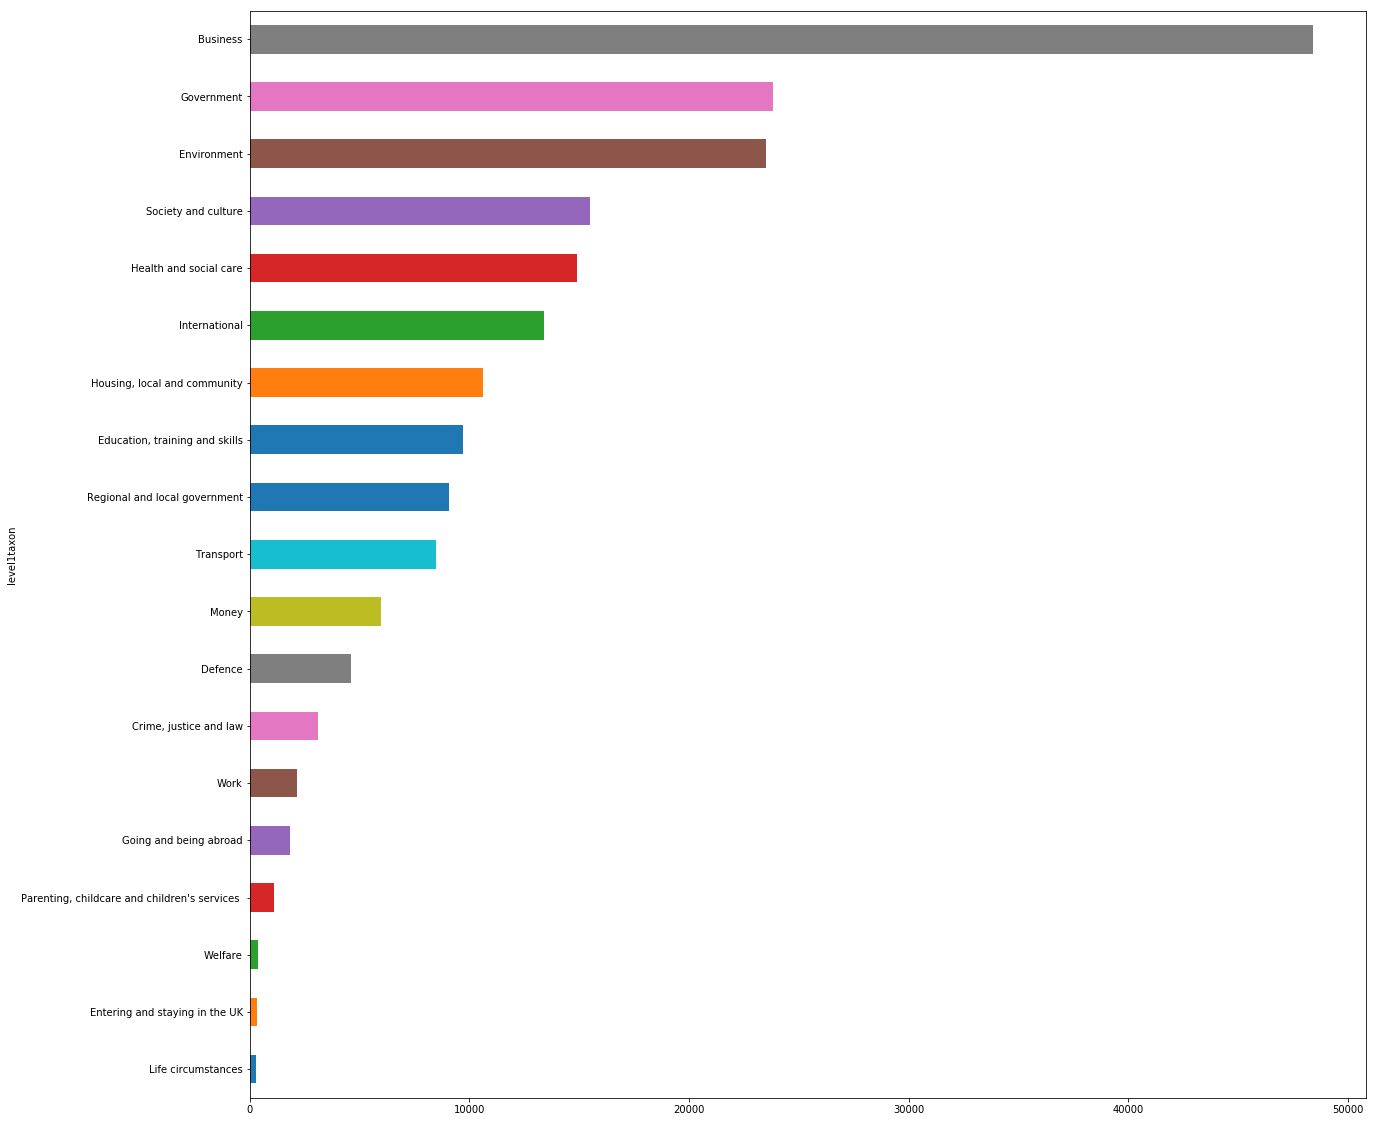

In [48]:
topfreq.sort_values().plot(kind = 'barh', figsize=(20, 20))

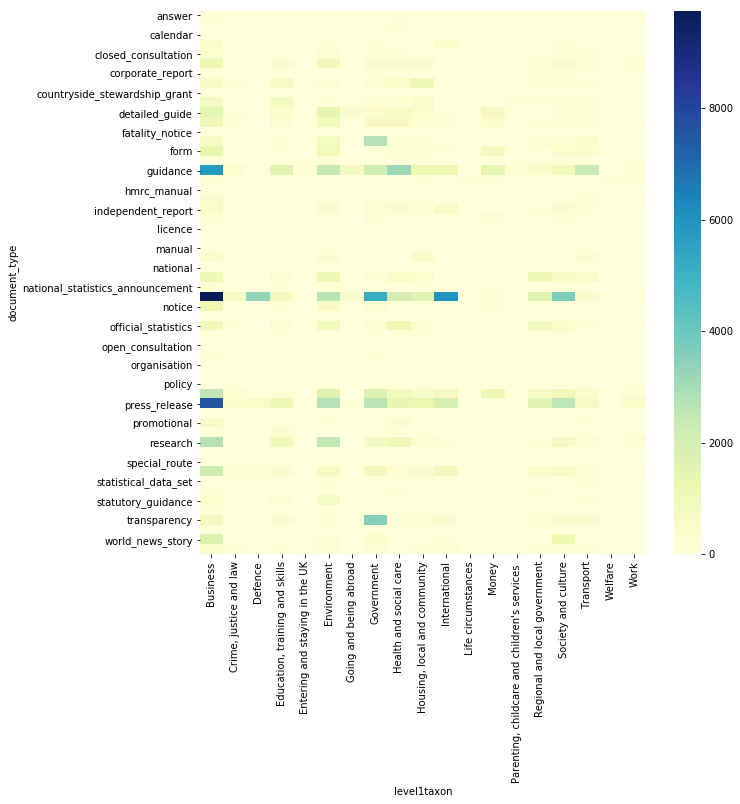

In [49]:
top_doctype = pd.crosstab(content_taxons_dedup['document_type'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(top_doctype, cmap = "YlGnBu")

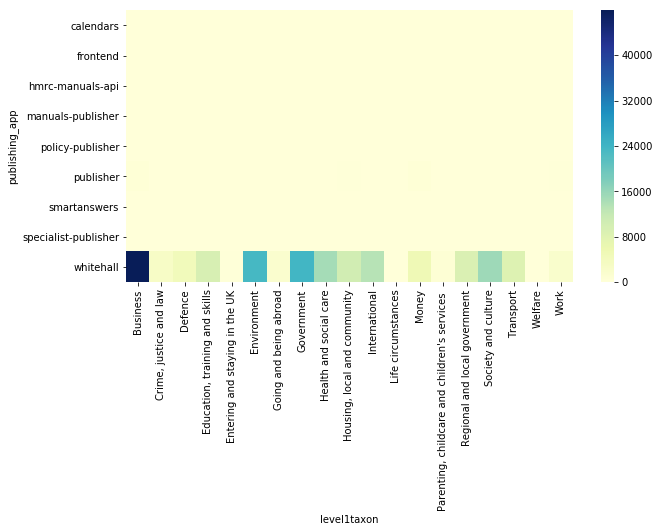

In [50]:
top_pubapp = pd.crosstab(content_taxons_dedup['publishing_app'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(top_pubapp, cmap = "YlGnBu")

In [51]:
content_taxons_dedup.groupby('level1taxon').size().sort_values(ascending=False)

level1taxon
Business                                         48397
Government                                       23809
Environment                                      23508
Society and culture                              15476
Health and social care                           14886
International                                    13409
Housing, local and community                     10637
Education, training and skills                    9690
Regional and local government                     9065
Transport                                         8468
Money                                             5971
Defence                                           4596
Crime, justice and law                            3094
Work                                              2158
Going and being abroad                            1841
Parenting, childcare and children's services      1081
Welfare                                            358
Entering and staying in the UK                     31

### Level 2 taxons

In [54]:
#assert content_taxons_dedup.level2taxon.nunique() == 103

print("There are {} unique taxon names in the level 2 taxon"
      .format(content_taxons_dedup.level2taxon.nunique()))

There are 103 unique taxon names in the level 2 taxon


In [55]:
second_freq = content_taxons_dedup.groupby('level2taxon').size().sort_values(ascending=False)

# Print as string to get around truncation

print(second_freq.to_string())



level2taxon
Foreign affairs                                                           5447
Climate change and energy                                                 4250
Business and enterprise                                                   3705
Trade and investment                                                      3487
Housing planning and building                                             2676
International aid and development                                         2618
School curriculum                                                         2492
Business tax                                                              2417
Housing                                                                   2148
Rail                                                                      2100
Dealing with HMRC                                                         1805
Business and the environment                                              1710
Maritime                                

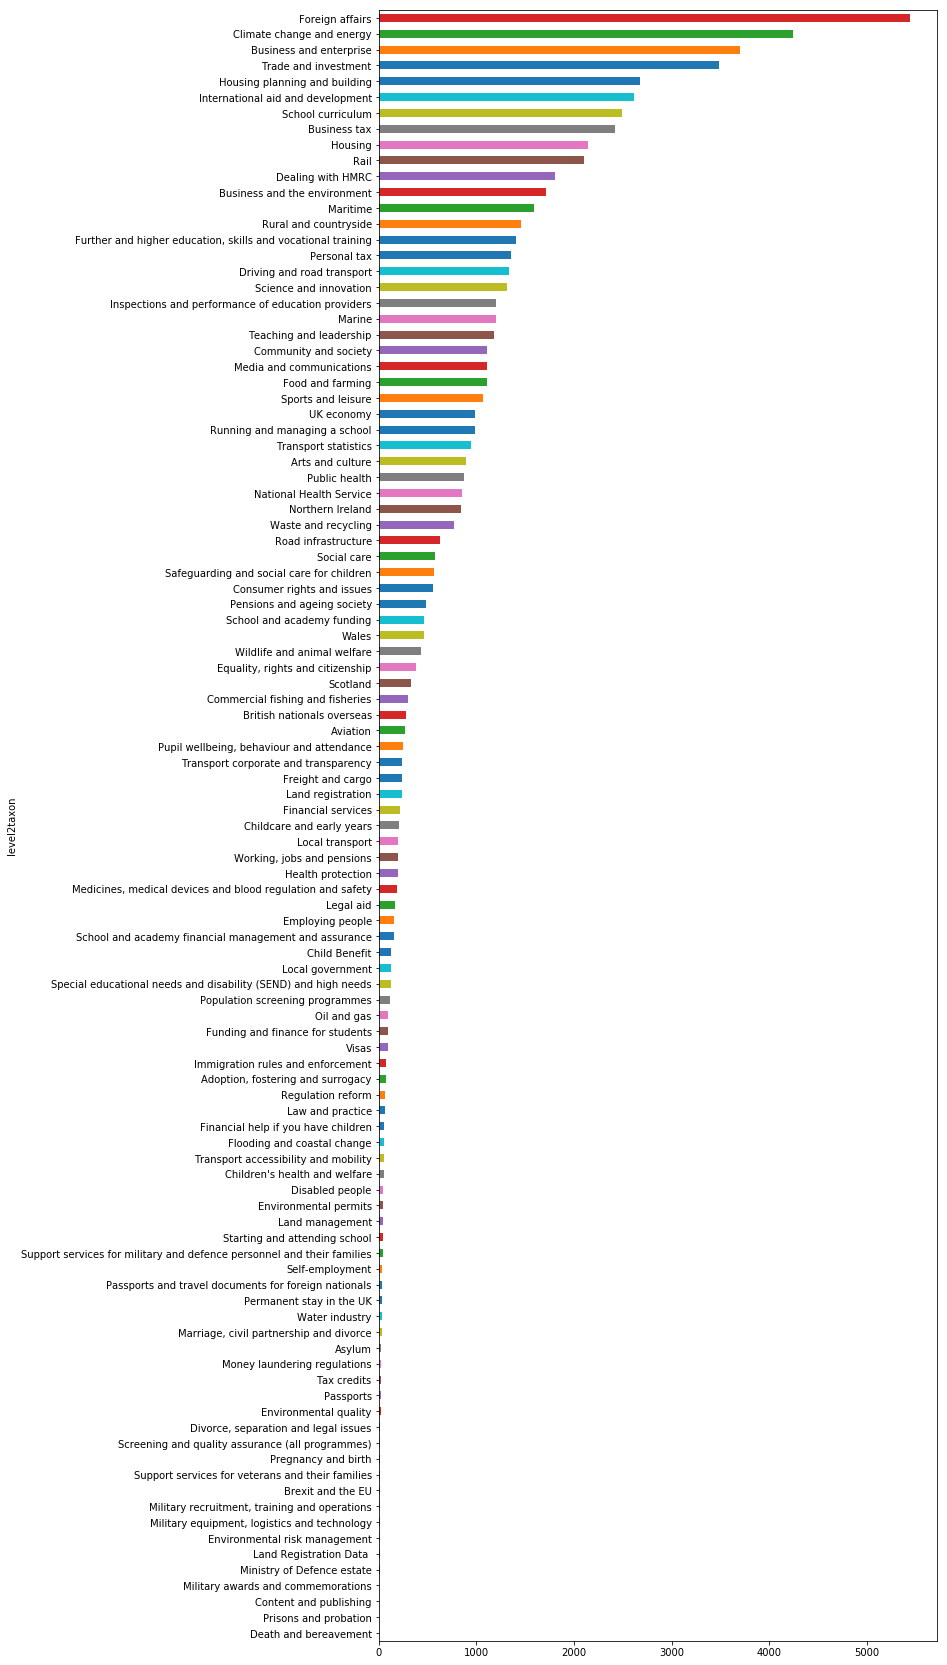

In [56]:
second_freq.sort_values().plot(kind = 'barh', figsize=(10,30))

## How much stuff is only tagged to level 1?

In [57]:
mask = ~content_taxons_dedup['level1taxon'].isnull() & content_taxons_dedup['level2taxon'].isnull()

print("There are {} out of {} content items with no level1 tag"
      .format(sum(content_taxons_dedup['level1taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level2 tag"
      .format(sum(~content_taxons_dedup['level2taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level1 tag, but no level2 tag"
      .format(sum(mask), content_taxons_dedup.shape[0]))

There are 32034 out of 229084 content items with no level1 tag
There are 68678 out of 229084 content items with a level2 tag
There are 128372 out of 229084 content items with a level1 tag, but no level2 tag


In [58]:
content_taxons_dedup['level1taxon'].head()

5    Education, training and skills
6    Education, training and skills
7    Education, training and skills
8    Education, training and skills
9    Education, training and skills
Name: level1taxon, dtype: object

<p style="border-radius: 25px;background: #73AD21;padding: 20px;width: 1000px;height: 50px;color: #FFFFFF;">Don't think this can be right as we know there are nones in level1taxon just by looking at head()??? ☝️☝️☝️☝️☝️</p>

In [59]:
# Since there are not missing level1 taxons, this does nothing, hence the warning!

content_taxons_dedup.loc[
    content_taxons_dedup['level1taxon'].isnull(), 'level1taxon'
] = content_taxons_dedup['taxon_name']



/Users/ellieking/Documents/tag_tax/govuk-taxonomy-supervised-learning/tax_SL/lib/python3.4/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [60]:
mask = ~content_taxons_dedup['level1taxon'].isnull() & content_taxons_dedup['level2taxon'].isnull()

print("There are {} out of {} content items with no level1 tag"
      .format(sum(content_taxons_dedup['level1taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level2 tag"
      .format(sum(~content_taxons_dedup['level2taxon'].isnull()), content_taxons_dedup.shape[0]))
print("There are {} out of {} content items with a level1 tag, but no level2 tag"
      .format(sum(mask), content_taxons_dedup.shape[0]))

There are 0 out of 229084 content items with no level1 tag
There are 68678 out of 229084 content items with a level2 tag
There are 160406 out of 229084 content items with a level1 tag, but no level2 tag


This function probably isn't needed anymore if we first convert NaNs to Nones

```
def replace_nan(level1, taxon_name):
    """
    
    :param level1: <str>
    :param taxon_name: <str>
    """
    if level1 == 'nan':
        level1 = taxon_name
    return level1
```

In [61]:

print(sum(content_taxons_dedup['level1taxon'].isnull()))
print(sum(content_taxons_dedup['level2taxon'].isnull()))
print(content_taxons_dedup.shape)

# This should no longer be needed.

#content_taxons_dedup['newcolumn'] = content_taxons_dedup.apply(lambda x: replace_nan(x['level1taxon'], x['taxon_name']), axis=1)


0
160406
(229084, 18)


In [62]:
# Not sure what you are doing here! Use pd.where if possible.

#content_taxons_dedup.loc['level1taxon'] = np.where(content_taxons_dedup['level1taxon'] == 'nan', content_taxons_dedup['taxon_name'].values, content_taxons_dedup['level1taxon'].values)

In [ ]:
content_taxons_dedup.where(content_taxons_dedup['level1taxon'] == 'nan').shape

In [ ]:
, content_taxons_dedup['taxon_name'].values, content_taxons_dedup['level1taxon'].values)

In [ ]:
content_taxons_dedup['level1taxon']

## Checking that all items tagged to lower level have a label in toptaxon and secondtaxon

In [ ]:
level1_2 = pd.crosstab(content_taxons_dedup['level1taxon'], content_taxons_dedup['level2taxon'])

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(level1_2, cmap = "YlGnBu")